# Introduction

Since the Russian invasion of Ukraine in February 2022, gas prices have peaked in the Netherlands [1].
While the government announced and instituted a price cap for the local households, still many people are affected by the high pricing today [1,2]. People have been and are still searching more than before what they can do in order to decrease their gas consumption[3,4]. We believe that there is therefore a significant basis to believe that people want to know their gas consumption, so they can calculate their payments for gas, and know much money that have left for other necessities or amenities. 

In this paper, we attempt to predict the gas usage of a residential home by looking at the time of day, the month and the outside temperature. While some research has already been done on this topic by [5], we believe that more research is adequate, since this topic is currently highly pertinent. 

We will try to predict gas usage using machine learning. We are interested in this, due to possible implications: people might get more insight in their future gas usage using this model based on their local weather forecast, and therefore are able to anticipate how much money they will have to save for their upcoming gas bill.

In [25]:
from home_messages_db import HomeMessagesDB
import sqlite3
import pandas as pd   
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb
sb.set_theme(style="darkgrid")   
import calendar
from scipy.stats import zscore
import statsmodels.api as sm
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression

# How to create the MyHome Database

To generate the database with the necessary files, please write the following code into the terminal 1 by 1:

cd [the directory which contain the downloaded files]

python generate_weatherdata.py -d sqlite:///myhome.db

python openweathermap.py -d sqlite:///myhome.db weatherdata.csv

python p1g.py -d sqlite:///myhome.db P1g-*.csv.gz

In [26]:
Database = HomeMessagesDB('sqlite:///myhome.db')

In [27]:
%load_ext sql
%sql sqlite:///myhome.db

The sql extension is already loaded. To reload it, use:
  %reload_ext sql


In [28]:
%%sql

sqldata << SELECT COALESCE(p.EpochId, o.time) AS time, p.TotalGas,
       COALESCE(o.temperature_2m, "NaN") AS temperature_2m
FROM p1g p
LEFT JOIN sources s ON p.SourceId = s.SourceId
LEFT JOIN openweathermap o ON o.time = p.EpochId
                            AND o.time >= 1672527600
WHERE p.EpochId >= 1672527600

*  sqlite:///myhome.db
Done.


# Cleaning and preparing of the Dataset

From the database, we create a dataframe containing the 3 existing variables of interest: *time* (in epoch time), *totalGas* (the cumulative gas consumption computed every 15 minutes), and *temperature_2m* (the weather temperature given for every fixed hour).

We start by removing all potential duplicates from the dataframe based on the time measurement which must be unique. Since the gas consumption is given with an accuracy of 15 minutes while the temperature is only given for every 60 minutes, we compute the marginal gas consumption per hour. To do so, we take the difference of total gas consumption of the 30 minutes past the fixed hour with the total gas consumption of the 30 minutes before the fixed hour. We select the value of every half past the fixed hours because this number is more representative of the marginal consumption throughout the given hour than the gas consumption indicated at the fixed hour. We name this marginal gas consumption variable *Gas_Difference*. We then remove all incomplete rows, which further decreases the size of our dataset. Indeed, the gas consumption measurements were 4 times more frequent than temperature measurements. From the initial 18490 incomplete/duplicated observations, we only keep 2253 unique and complete observations at the end of our cleaning process.

We decide to keep all our variables continuous. Temperature and gas consumption are of course continuous. The 24 hours of the day are discrete since they are represented as integers ranging from 0 to 23, but we decide to not treat *hour* as a categorical variable considering the large amount of categoties (24) and considering that we want to keep the notion of continuity of time in the model. Similarly, we decide to keep *month* as continuous. *Month* only contains 4 values (from 1 to 4) since our dataset is restricted to a duration of less than 4 complete months. We decide to keep this variable numerical and continuous because we want to account for the continuous progression from winter (January) to spring (April).

Lastly, we decide to scale our predictors. We are aware that scaling the predictors will hinder interpretability of the results. However, we believe it is necessary to avoid any imbalances in the variables, which have different scales. By doing so, we ensure that all variables weigh equally in the models and that we capture correctly the relative relationships of the different predictors on the outcome.

For our data exploration, we are interested in the overall trends per month, and for our analysis, we are interested in the hour of the day of each measurement; we want to observe whether there is a trend for some hours to correspond to higher/lower gas consumption levels. We therefore create a new variable *dateTime* which convert the epoch time into date time. We added one hour due to our data being from the Netherlands (GMT +1) and, due to daylight saving time, we added an aditional hour to all datapoints located after the date 2023-03-26, 02:00:00. From this *dateTime* variable, we create 2 new variables of interest: one (*month*) which only considers the part of the date informative about the month of each observation, and another one (*hour*) which only selects the part of the date informative about the hour, neglecting the information relating to the day/month/year.

In [29]:
# Transfer sql query into pandas dataframe
df = pd.DataFrame(sqldata)

# Remove any potential duplicates from the dataframe
df = df[~df['time'].duplicated()] 

# To be able to calculate gas difference data, resetting of the index is helpful
df = df.reset_index(drop=True)

# Calculate the gas difference between half hour past temperature measurement, and half hour before.
def calculate_gas_difference(row):
    if row.name % 4 == 0 and row.name != 0:
        return df.loc[row.name + 2, 'TotalGas'] - df.loc[row.name - 2, 'TotalGas']
    else:
        return np.nan

df['Gas_Difference'] = df.apply(calculate_gas_difference, axis=1)

# Make a column without Na's in temperature: Store data per hour
df = df[df['temperature_2m'] != "NaN"] 

In [30]:
# Make a dateTime column from the Epoch time
df["dateTime"] = pd.to_datetime(df["time"], unit="s")

# Change to add one hour to adjust for timezone 
df['dateTime'] += pd.Timedelta(hours=1)

# Change for daylight saving time
rows_to_update = df['dateTime'] >= pd.to_datetime('2023-03-26 02:00:00')
df.loc[rows_to_update, 'dateTime'] += pd.Timedelta(hours=1)

# Add columns for hour of the day, month of the year, and difference in Gas between hour before and now
df["hour"] = df["dateTime"].dt.hour
df["month"] = df["dateTime"].dt.month

# Reset index for clarity
df = df.reset_index(drop=True)

# Data Exploration

Before fitting any model, we are interested in the basic statistics of our data. We first create a trable depicting the average marginal gas consumption per hour for each month as well as the average temperature for month. We notice that, while the average gas consumption monotonically decreases as months pass by, the average temperature remains quite stagnant around 6° - 7° C.

In [31]:
# Compute mean gas consumption per time units (hour, month)
GasPerHour = df.groupby("hour")["Gas_Difference"].mean() 
GasPerMonth = df.groupby("month")["Gas_Difference"].mean()
TempPerMonth = df.groupby('month')['temperature_2m'].mean()

# Create Table
table = pd.DataFrame({"Month": ["January", "February", "March", "April"],
                     "Average gas consumption": round(GasPerMonth, 3),
                     "Average Temperature": round(TempPerMonth, 3)})
table = table.set_index(keys = "Month",drop = True)
table

,Average gas consumption,Average Temperature
Month,,
January,0.305,6.236
February,0.279,6.133
March,0.229,6.912
April,0.196,6.557


We shall observe the data in more detail with the help of a plot.
We smooth the data of both the temperatures and the marginal gas consumption through the use of a rolling mean. We use a window size of 50. Here below, one can visualize the evolution of both gas consumption and temperature through time. On the left vertical axis, one can see the unit measurement of gas consumtions (in m<sup>3</sup>), and on the right vertical axis, the measurement scale for temperature (in C°). Please note that the temperature scale is in **reverse**. The horizontal axis represent time, measured in months. The correlation between gas consumption and temperature levels is apparent from the graph.

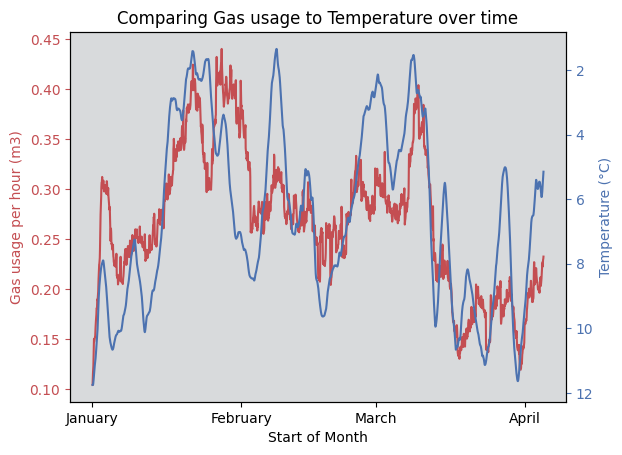

In [32]:
window_size = 50

graphic = df.copy()

graphic['temperature_2m_smooth'] = graphic['temperature_2m'].rolling(window_size, center=True, min_periods=1).mean()
graphic['Gas_smooth'] = graphic['Gas_Difference'].rolling(window_size, center=True, min_periods=1).mean()

# Set the plot style/theme
with plt.style.context('default'):
    # Create figure and axes objects
    fig, ax1 = plt.subplots()

    # Plot smoothed Gas on left y-axis
    ax1.plot(graphic['dateTime'], graphic['Gas_smooth'], 'r-', label='Gas')
    ax1.set_xlabel('Start of Month')
    ax1.set_ylabel('Gas usage per hour (m3)', color='r')
    ax1.tick_params('y', colors='r')
    ax1.set_facecolor('#D8DADC')

    # Create a second y-axis for smoothed Temperature
    ax2 = ax1.twinx()
    ax2.plot(graphic['dateTime'], graphic['temperature_2m_smooth'], 'b-', label='Temperature')
    ax2.set_ylabel('Temperature (°C)', color='b')
    ax2.tick_params('y', colors='b')

    # Reverse the y-limits of the left y-axis
    ax2.set_ylim(ax2.get_ylim()[::-1])

    # Set x-axis tick locations and labels
    start_date = pd.to_datetime('2023-01-01')
    end_date = pd.to_datetime('2023-04-01')
    tick_locations = pd.date_range(start=start_date, end=end_date, freq='MS')
    tick_labels = [calendar.month_name[dt.month] for dt in tick_locations]
    ax1.set_xticks(tick_locations)
    ax1.set_xticklabels(tick_labels)

    # Display the plot
    plt.title('Comparing Gas usage to Temperature over time')
    plt.show()

Lastly, we are interested in seeing whether certain hours of the day correspond to higher uses of gas. The plot below is a scatteplot showing the average gas consumption of the household for each of the 24 hours of the day. There seems to be a clear peak around 6am which gradually decreases in the late morning and early afternoon, then an increase again from the middle afternoon to 9pm, reaching it's maximum, before tumbling down again and staying low during the night until the next morning.

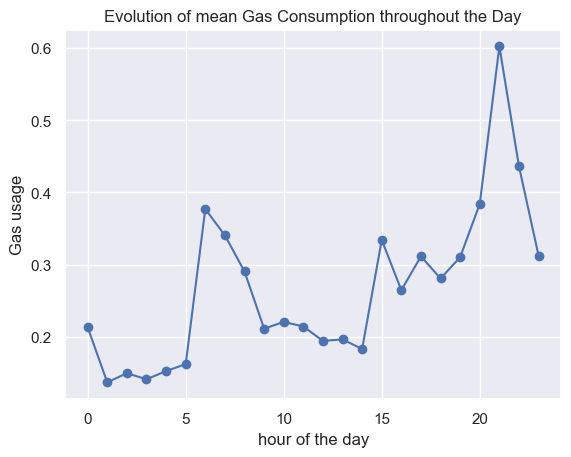

In [33]:
plt.scatter(x=range(24), y=GasPerHour)
plt.plot(range(24), GasPerHour, '-')
plt.ylabel("Gas usage")
plt.xlabel("hour of the day")
plt.title("Evolution of mean Gas Consumption throughout the Day")
plt.show()

# Analysis

We are interested in predicting the consumption of gas of the household based on weather information. We shall run several models to predict the consumption of gas: firstly, we fit a simple linear regression with weather temperature as the predictor and gas consumption as the outcome. Secondly, we fit a multiple linear regression with weather temperature, the hour of the day and the month in which the events take place as predictors, and gas consumption as the outcome variable. Lastly, we fit a multiple regression includiong the three regressors previously mentioned as well as the interaction terms between these three preidctors, and again, gas consumption as the outcome variable.

## Simple Linear Regression

We first divide our dataset into a training set of predictors, a training set of responses, a testing set of predictors, and a testing set of response. All 4 sets are of type *array* from numpy.  We randomly select 70% of the observations for our training sets, and the remaining 30% are used for testing the model. We then fit a linear regression model on the training set and use it on the test set to create predictions of gas consumptions. Finally, we compute the mean squared error (MSE) to assess the predictive power of our model: we obtain an MSE of 0.05053. While this number seems small, one should not forget the scale of our outcome variable: 0.05053 is a relatively big MSE considering the scale of the outcome *Gas_difference*, of which the values are all included between 0 and 2m<sup>3</sup>.

In [34]:
# Separate feature from outcome
X = df["temperature_2m"].astype("float")
Y = df["Gas_Difference"].astype("float")
X = X.values.reshape(-1, 1)
Y = Y.values.reshape(-1, 1)

# Scale the features using StandardScaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split in train and test set
x_train, x_test, y_train, y_test = train_test_split(X_scaled, Y, test_size=0.30, random_state=22)

In [35]:
model = LinearRegression()

model.fit(x_train, y_train)
y_pred = model.predict(x_test)  

# Compute accuracy
mse = mean_squared_error(y_test, y_pred, squared=True)
print("Mean Squared Error:", round(mse, 5)) 

Mean Squared Error: 0.05053


We can explore the distribution of our predictions and compare it to the true values. Here below, in the right panel, the densities of both the predicted and true gas consumption curves are depicted. One can observe that the true gas consumption has very thick tails and is rightly skewed, making it more complex to predict the actual values. In comparison, the probability density function of the predicted outcome has very narrow tails. However, the predicted distribution seems to be centered appropriately. Indeed, both means are very close to each other: the mean true gas consumption is 0.26757, while the mean of the predicted gas consumption is 0.26992. In the left panel, one can see the distribution of the predicted gas consumptions against the real gas consumptions of our testing set. We observe that the predictions are all in the interval (0.15, 0.4), and while the model is decent at predicting for small values of actual gas consumption, it is very bad at predicting larger amounts of gas consumption. We also notice that the vast majority of the observations have a true value within (0, 0.5) with a few outliers which can range up to 2m<sup>3</sup>. 

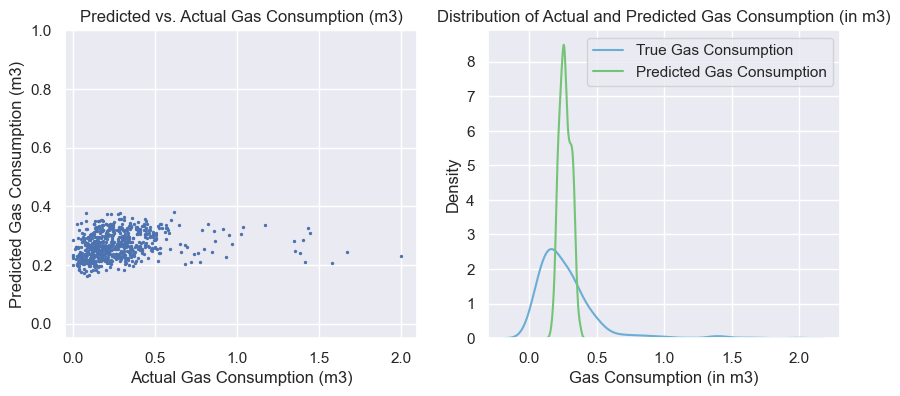

Mean of predicted gas consumption: 0.26992
Mean of true gas consumption: 0.26757


In [36]:
fig, axs = plt.subplots(1, 2, figsize=(10, 4))

axs[0].scatter(y_test, y_pred, s=2)
axs[0].set_xlabel('Actual Gas Consumption (m3)')
axs[0].set_ylabel('Predicted Gas Consumption (m3)')
axs[0].set_xlim([-0.05, 2.1])
axs[0].set_ylim([-0.05, 1])
axs[0].set_title('Predicted vs. Actual Gas Consumption (m3)')

sb.kdeplot(y_test, label="True Gas Consumption", palette = "Blues")
sb.kdeplot(y_pred, label="Predicted Gas Consumption", palette="Greens")
axs[1].set_xlabel("Gas Consumption (in m3)")
axs[1].set_ylabel("Density")
axs[1].set_title("Distribution of Actual and Predicted Gas Consumption (in m3)")
axs[1].legend()
plt.show()
y_test_mean = np.mean(y_test)
y_pred_mean = np.mean(y_pred)
print("Mean of predicted gas consumption:", round(y_test_mean, 5))
print("Mean of true gas consumption:", round(y_pred_mean, 5))

Since some outliers truly impact the model and the quality of the predictions, we decide to exculde them. We defined our outliers as having a either a value of three times the standard deviation above the mean, or three times below the mean. Based on this definition, we removed the 47 outliers, which only accounts for 2.09% of the dataset. We now run the analysis again on the new dataset, and the remaining of the analysis will be carried on this new, reduced dataset. The resulting MSE is 0.02344 as opposed to 0.05053 when keeping the outliers.

In [37]:
# Calculate z-scores for 'Gas_Difference' column
df_filter = df.copy()
df_filter['Gas_Difference_zscore'] = zscore(df_filter['Gas_Difference'])

# Filter the DataFrame based on z-score threshold
threshold = 3
df_filtered = df_filter[abs(df_filter['Gas_Difference_zscore']) <= threshold]

# Drop the rows with outliers
df_reduced = df_filtered.dropna(subset=['Gas_Difference_zscore'])

df_reduced = df_reduced.drop('Gas_Difference_zscore', axis=1)


In [38]:
X = df_reduced["temperature_2m"].astype("float")
Y = df_reduced["Gas_Difference"].astype("float")
X = X.values.reshape(-1, 1)
Y = Y.values.reshape(-1, 1)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
# Split in train and test set
x_train, x_test, y_train, y_test = train_test_split(X_scaled, Y, test_size=0.30, random_state=22)

model = LinearRegression()

model.fit(x_train, y_train)
y_pred = model.predict(x_test)  

# Compute accuracy
mse = mean_squared_error(y_test, y_pred, squared=True)
print("Mean Squared Error:", round(mse, 5)) 

Mean Squared Error: 0.02344


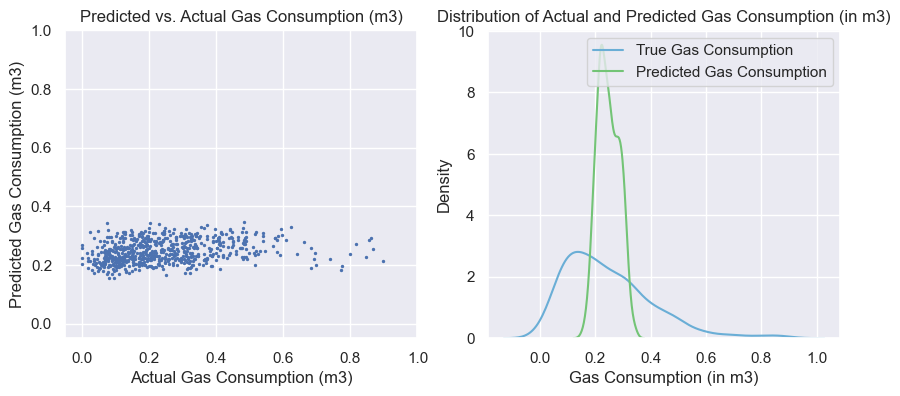

Mean of predicted gas consumption: 0.2467
Mean of true gas consumption: 0.24721


In [39]:
fig, axs = plt.subplots(1, 2, figsize=(10, 4))

axs[0].scatter(y_test, y_pred, s=2)
axs[0].set_xlabel('Actual Gas Consumption (m3)')
axs[0].set_ylabel('Predicted Gas Consumption (m3)')
axs[0].set_xlim([-0.05, 1])
axs[0].set_ylim([-0.05, 1])
axs[0].set_title('Predicted vs. Actual Gas Consumption (m3)')

sb.kdeplot(y_test, label="True Gas Consumption", palette = "Blues")
sb.kdeplot(y_pred, label="Predicted Gas Consumption", palette="Greens")
axs[1].set_xlabel("Gas Consumption (in m3)")
axs[1].set_ylabel("Density")
axs[1].set_title("Distribution of Actual and Predicted Gas Consumption (in m3)")
axs[1].legend(loc = "upper right")
plt.show()
y_test_mean = np.mean(y_test)
y_pred_mean = np.mean(y_pred)
print("Mean of predicted gas consumption:", round(y_test_mean, 5))
print("Mean of true gas consumption:", round(y_pred_mean, 5))

Finally we can inspect our results. We observe that our predictor *temperature* is very relevant in predicting the outcome, with a p-value of 1.43e-23. For an increase of 1 in temperature, the gas consumption goes down by 0.039. This result is coherent because we expect the inhabitants to heat the house less if the outside temperature is warmer. Please bear in mind that an increase of 1 cannot be considered as an increase of 1°C because we have scaled the predictors.

In [40]:


mod = sm.OLS(y_train.astype(float),sm.add_constant(x_train.astype(float)))
myModel = mod.fit()
results = myModel.summary2().tables[1]
results

,Coef.,Std.Err.,t,P>|t|,[0.025,0.975]
const,0.246067,0.003781,65.076519,0.000000e+00,0.238650,0.253484
x1,-0.038563,0.003791,-10.172535,1.431546e-23,-0.045999,-0.031127


# Multiple Linear Regression

Simple linear regression might not be appropriate for our situation. We shall try to fit a multiple linear regression using as predictors the temperature, the time of the day, and the month in which the observation is measured.
Similarly to our Simple linear regression, we start by splitting our dataset into a training set of predictors, which includes the 3 variables *temperature_2m*, *hour* and *month*, a training set of responses, a testing set of predictors (which includes the same 3 variables as the training set of predictors), and a testing set of response. Again, we select randomly 70% of the observations for our training sets, and the remaining 30% are used for testing the model. We then fit a linear regression model on the training set and use it on the test set to create predictions of gas consumptions. Finally, we compute the mean squared error (MSE): we obtain an MSE of 0.14132. Surprisingly, this MSE is significantly higher than the MSE of the simple linear regression, which was 0.02344.

In [41]:
# Separate features from outcome
features = ["temperature_2m", "hour", "month"]
target = "Gas_Difference"
X, Y = df_reduced[features], df_reduced[target]

# Scale the features using StandardScaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


# Split into train and test set
x_train, x_test, y_train, y_test = train_test_split(X_scaled, Y, test_size=0.30, random_state=22)

# Fit the model
model = LinearRegression()
model.fit(x_train, y_train)
y_pred = model.predict(x_test)

# Compute accuracy
rmse = mean_squared_error(y_test, y_pred, squared=False)
print("Mean Squared Error:", round(rmse, 5))

Mean Squared Error: 0.14132


We should now compare the distribution of our predictions to the true values. Here below, the left panel shows the distribution of the predicted gas consumptions against the real gas consumptions of our testing set. We observe that the predictions have a wider range than in the simple linear regresion. However, it is still bad at predicting large amounts of gas consumption. This result was to be expected since we kept all the outliers, and we still did not account for nonlinearity in this model.
Once again, the densities of both the predicted and true gas consumption curves are depicted in the right panel. While the distribution of the predicted gas consumption is closer to the true curve using this model than the previous model, there is still improvement to be made. The mean of the predicted distribution is still correctly located: the mean true gas consumption is 0.24701, while the mean of the predicted gas consumption is 0.2467.

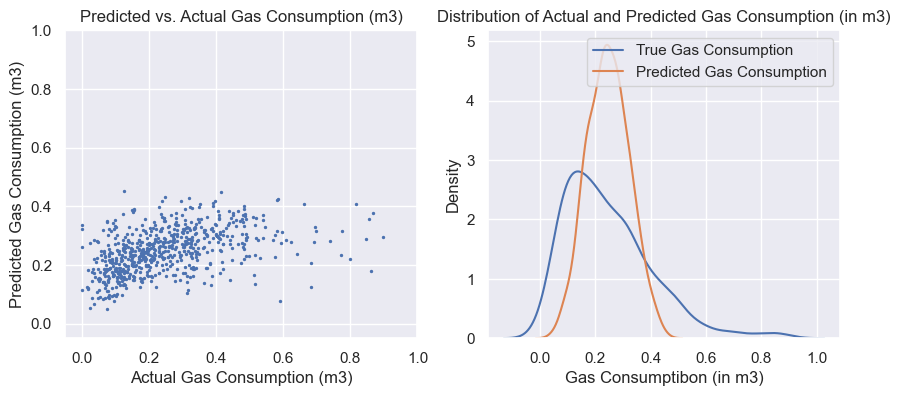

Mean of predicted gas consumption: 0.2467
Mean of true gas consumption: 0.24701


In [42]:
fig, axs = plt.subplots(1, 2, figsize=(10, 4))

# Plot 1 - Scatter plot
axs[0].scatter(y_test, y_pred, s=2)
axs[0].set_xlabel('Actual Gas Consumption (m3)')
axs[0].set_ylabel('Predicted Gas Consumption (m3)')
axs[0].set_xlim([-0.05, 1])
axs[0].set_ylim([-0.05, 1])
axs[0].set_title('Predicted vs. Actual Gas Consumption (m3)')

# Plot 2 - KDE plot
sb.kdeplot(y_test, label="True Gas Consumption", ax=axs[1])
sb.kdeplot(y_pred, label="Predicted Gas Consumption", ax=axs[1])
axs[1].set_xlabel("Gas Consumptibon (in m3)")
axs[1].set_ylabel("Density")
axs[1].set_title("Distribution of Actual and Predicted Gas Consumption (in m3)")
axs[1].legend(loc = "upper right")

plt.show()

# Calculate means
y_test_mean = np.mean(y_test)
y_pred_mean = np.mean(y_pred)
print("Mean of predicted gas consumption:", round(y_test_mean, 5))
print("Mean of true gas consumption:", round(y_pred_mean, 5))

From the table, we observe that the intercept is 0.246, which is the predicted mean gas consumption when all the predictors are theoretically set to 0. For readability, please bear in mind that *x1* represents the temperature, *x2* is the hour of the day and *x3* is the month. From the p-values, we see that all predictors are very relevant in predicting the outcome, especially *temperature* and *hour*. An increase of 1 in scaled *temperature* leads to a decrease of 0.046m<sup>3</sup>
 of gas consumption on average. An increase of 1 in scaled *hour* (so later relative to the 24 hours of a day) leads to an average increase of 0.055m<sup>3</sup>
 of gas consumption. Lastly, an increase of 1 in scaled *month* leads to av average decrease of gas consumption of 0.030m<sup>3</sup>.

In [43]:
mod = sm.OLS(y_train.astype(float),sm.add_constant(x_train.astype(float)))
myModel = mod.fit()
results = myModel.summary2().tables[1]
results

,Coef.,Std.Err.,t,P>|t|,[0.025,0.975]
const,0.246006,0.003434,71.640389,0.000000e+00,0.239271,0.252742
x1,-0.046293,0.003521,-13.146092,1.724545e-37,-0.053200,-0.039386
x2,0.055247,0.003530,15.650795,2.382388e-51,0.048323,0.062171
x3,-0.030190,0.003455,-8.737194,6.117222e-18,-0.036968,-0.023413


## Polynomial multiple regression with interaction

Lastly, we fit a polynomial multiple linear regression which takes as regressors the temperature, the time of the day and the month, their polynomials to the second degree, and we include interactions terms up to the second degree. We have chosen this model because it allows for polynomial terms which can capture the nonlinearity of the data. Furthermore, we include interaction terms to see if some of the predictors interact with each other when predicting gas consumption, and we allow for nonlinear interactions as well. This model creates predictions with an MSE of 0.14166. Once again, we present a scatterplot of the true against predicted value of gas consumption, and we present the density functions of both the predicted and true gas consumptions.

In [44]:
# WITH INTERACTION

# Separate features from the outcome
features = ["temperature_2m", "hour", "month"]
target = "Gas_Difference"
X, Y = df_reduced[features].astype("float"), df_reduced[target].astype("float")

# Add interaction terms using PolynomialFeatures
poly = PolynomialFeatures(degree=2, interaction_only=True, include_bias=False)
X_interactions = poly.fit_transform(X_scaled)

# Scale the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split into train and test sets
x_train, x_test, y_train, y_test = train_test_split(X_interactions, Y, test_size=0.30, random_state=22)

poly = PolynomialFeatures(degree=2)
x_train_poly = poly.fit_transform(x_train)
x_test_poly = poly.transform(x_test)

# Fit polynomial regression model
model = LinearRegression()
model.fit(x_train_poly, y_train)
y_pred = model.predict(x_test_poly)

# Compute accuracy
rmse = mean_squared_error(y_test, y_pred, squared=False)
print("Mean Squared Error:", round(rmse, 5))


Mean Squared Error: 0.1416


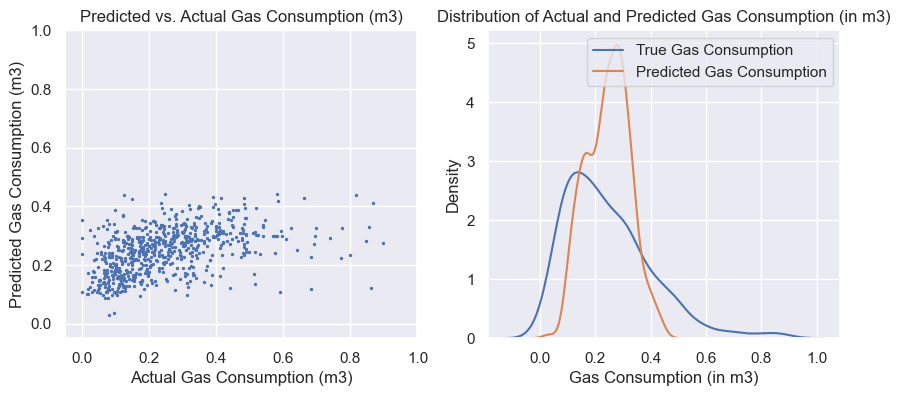

Mean of predicted gas consumption: 0.2467
Mean of true gas consumption: 0.24679


In [45]:
fig, axs = plt.subplots(1, 2, figsize=(10, 4))

# Scatter plot
axs[0].scatter(y_test, y_pred, s=2)
axs[0].set_xlabel('Actual Gas Consumption (m3)')
axs[0].set_ylabel('Predicted Gas Consumption (m3)')
axs[0].set_xlim([-0.05, 1])
axs[0].set_ylim([-0.05, 1])
axs[0].set_title('Predicted vs. Actual Gas Consumption (m3)')


# KDE plot
sb.kdeplot(y_test, label="True Gas Consumption", ax=axs[1])
sb.kdeplot(y_pred, label="Predicted Gas Consumption", ax=axs[1])
axs[1].set_xlabel("Gas Consumption (in m3)")
axs[1].set_ylabel("Density")
axs[1].set_title("Distribution of Actual and Predicted Gas Consumption (in m3)")
axs[1].legend(loc = "upper right")

plt.show()

# Calculate means
y_test_mean = np.mean(y_test)
y_pred_mean = np.mean(y_pred)
print("Mean of predicted gas consumption:", round(y_test_mean, 5))
print("Mean of true gas consumption:", round(y_pred_mean, 5))

When reading the table below, *x1* represents the scaled temperature, *x2* represents the scaled hour of the day and *x3* represents the scaled month. *x4*, *x5* and ¨*x6* are the interaction terms. When observing the coefficients of each predictor, we first notice that temperature and hour are still considered extremely strong predictors, with p values 2.10e_37 and 4.87e_51 respectively, and month is a less strong but still very strong predictor as well, with p-value 1.05e_17. We also notice that none of the interaction terms are relevant in predicting the gas consumption. By exploring further the parameters estimates, we conclude that the model did not capture quadriatic relationships in the data, neither in the relationship between the predictors and the outcome, nor in potential interactions between the predictors.
Overall, as the scaled hour increase by 1, the gas consumption goes down by 0.046m<sup>3</sup>. As scaled hour goes up by 1, the gas consumption goes up on average by 0.055m<sup>3</sup>. Lastly, as scaled month goes up by 1, gas consumption decrease on average by 0.030m<sup>3</sup>. However, one must keep in mind that this dataset only has 4 months from January to April, among which the month of April only includes a few days; therefore, these estimates must be interpreted with care.

In [46]:
mod = sm.OLS(y_train.astype(float),sm.add_constant(x_train.astype(float)))
myModel = mod.fit()
results = myModel.summary2().tables[1]
results

,Coef.,Std.Err.,t,P>|t|,[0.025,0.975]
const,0.246628,0.003516,70.148375,0.000000e+00,0.239731,0.253524
x1,-0.046441,0.003537,-13.130316,2.097346e-37,-0.053379,-0.039503
x2,0.055245,0.003542,15.599084,4.873916e-51,0.048298,0.062192
x3,-0.030029,0.003462,-8.672946,1.051431e-17,-0.036821,-0.023238
x4,-0.001934,0.003537,-0.546710,5.846576e-01,-0.008872,0.005004
x5,-0.002946,0.003485,-0.845374,3.980335e-01,-0.009783,0.003890
x6,-0.000238,0.003569,-0.066674,9.468502e-01,-0.007239,0.006763


# Conclusion

To conclude, our best model is the simple linear regression with only outside temperature as predictor to predict the gas consumption. It has an MSE is 0.02344, which is considerably lower than the 2 other models which had MSEs of 0.14132 for the multiple linear regression, and MSE of 0.14166 for the multiple regression model which included interaction terms. However, all models indicated that the outside temperature was a strong predictor for gas consumption, showing that an increase of temperature led, on average, to a significant decrease of gas consumption.

# Discussion

Based on our models, it is hard to correctly predict the gas consumption based on the weather. We did find that there is a trend, and that we can, very roughly, predict the gas usage, but it is nowhere near perfect. We believe that this might be limited due to a multiple of factors. 

For instance, the weather in this given period fluctuated quite a lot, and the fluctuations lasted only a couple of days. We are unsure whether the house was well isolated or not, and if the house is well insulated, the impact of a few days cold weather might be significantly reduced. Furthermore, it can take humans some time to adjust their thermostat [6], and therefore the effect of these small fluctuations in the weather might be quite insignificant. Furthermore, due to the increase of gas prices in the Netherlands stated in the introduction, people might be more careful with turning up the thermostat. 

Another limitation that we had, is that this data is quite limited. We only have data from one household in a small period. If we had multiple households over a few years, we might be able to predict the annual costs better.

We also did not have a lot of information about the household: We did not know the amount of people living there, what kind of heating system they used, what kind of insulation they have, but also time related questions, like when they go to work, when they come back home, when they start sleeping. All this information also impacts the way we can work with our data. For instance, if we knew their schedule, we could have added a variable ‘At Home’ to the dataset, since most often not a lot of gas is used when people are not home. We tried to mimic this by adding the variable ‘hour’ to the Multiple Linear Regression, but this sadly did not improve our plot.

If another study is done on the topic of using machine learning to predict gas usage in household residents, we would suggest a larger sample size, and a longer period. 

When recommending additional study on this topic based on our dataset, we would recommend looking at wind and rainfall. Furthermore, isolation might be measured by watching the temperature inside drop, when the heater is off, based on the outside temperature. This was, however, beyond the scope of our paper.

# Comments on Usage of ChatGPT

I (Timon Huijser) will share my experiences using ChatGPT for this exercise.

The main advantage is that it can really help with efficiently debugging the code. It is really good at looking for small errors, and adjusting the code for you to get it to work. 

For generating code on command, it is a bit less useful. Sure, it can give you some groundwork, but it is often wrong. Luckily, it has the ability to correct itself. However, when you ask it to correct itself, it often comes up with a more complex solution. You have to be careful when using it to not make your code too complex for no reason, which is the way it tends to fix things. When you notice that it does that, it can often be helpful to open a new chat with it, and ask the question again, but try to direct it more.

When we were debugging code in the terminal, what I would do is paste the entirety of the home_messages_db.py code and the openweathermap.py code, together with the code for the terminal and the error for the terminal. While it often would have the answer wrong, it was still easier than trying to fathom what we did wrong ourselves. It took quite some time, but eventually he could help us fix our mistakes. I did notice that pasting everything together fixed a main problem of using ChatGPT: Its limited memory. Often when asking questions, it forgot previous questions or information you had given, or even the code it itself provided. When pasting everything together, it could use all the information it had been given. When I noticed that he had memory problems, I simply opened a new chat, took a step back, and tried to fix the code further.

When using ChatGPT, it is still really important to roughly know what you are doing. However, you do not have to be perfectly capable of understanding the specific lines of the code, more the priniciples of coding itself. Even though I personally have not followed the statistical courses, due to an injury in my arms that has prevented me from following the basics of statistics, I was still able to help Alice with debugging the Statistical part of coding with minimal knowledge of the material, by asking ChatGPT what there was possibly wrong, and to search in the code itself for flaws.

I am unsure whether using it always saves you time, because sometimes it can lead you into a rabbit hole of worsening your code step by step, but it helps a lot when you have been busy coding for an entire day, when your brain is not able to function properly anymore and your motivation is at a low, to still keep going and to try come up with new ideas. Without it, I may have thrown in the towel multiple times because the code simply did not work.

Furthermore, you also do have to be aware that ChatGPT currently does not have recent data, only data from 2019 and earlier.

So, to conclude:
It is really good at debugging your code, and quite good at giving you an idea on how to tackle a problem.
It is quite poor at admitting that it is wrong or does not know, and it has quite a limited memory.
I do not think that by allowing ChatGPT to help you, you would get worse at coding. It really is a tool that helps you to code better and more efficiently. It often refreshes your memory on what you have learned in the lectures, but forgot, and it can help you with finding new ways to solve problems, new functions you did not know existed, etc. You also still need to understand what you are doing, but with it, you can create greater things that you could make realying solely on your own memory or other internet sources.


I (Alice Abramowicz) will also share my impressions of chatGPT in the context of this report. 

ChatGPT appeared to be very useful to give a first impression of how to code what we have in mind in the early stages of a blurry idea, when we are confused as to how to structure and implement it in python. It will probably not give a fully correct code but it gives good indications of what libraries and functions to use, and it also presents an option of template to structure the code. We are then free to use it completely, partly, or not at all and go for a different route. 

Also, ChatGPT can sometimes be very useful in more advanced stages of the coding process, when we are stuck on some error that we do not understand. It can be quite helpful with debugging. However, in these cases, it frequently goes into a loophole and drags us with it, making us waste time and worsening the code bit by bit. When this happens, it is usually best to leave chatGPT aside and try using (either common sense, if this was not done properly yet), or regular google searches, which shows many different sources and solutions to problems similar to the one we are confronted to.

I do believe that the use of chatGPT, just like any sort of comfort or easy route, has the danger of making us quite lazy. ChatGPT is an advanced technology which can often create code faster and better than us, and it is tempting to delegate the work to this intelligence out of laziness, to save energy, even if we would be able to code it by ourselves if we put in some efforts.

# Sources

[1] "Wat doet de ACM tegen de hoge energieprijzen?" Autoriteit Consument en Markt. https://www.acm.nl/nl/onderwerpen/energie/de-energiemarkt/de-energiemarkt/wat-doet-de-acm-tegen-de-hoge-energieprijzen [accessed 2023 June 6]

[2] "Prijsplafond voor gas, stroom en stadsverwarming" Rijksoverheid. https://www.rijksoverheid.nl/onderwerpen/koopkracht/plannen-kabinet-met-prijsplafond-voor-gas-en-elektriciteit [accessed 2023 June 6]

[3] "Google Trends" Google. https://trends.google.com/trends/explore?date=today%205-y&geo=NL&q=gasprijzen&hl=en [accessed 2023 June 6]

[4] "Hoge gasprijs: wat kun je doen?" Kamer van Koophandel. https://www.kvk.nl/duurzaamheid/hoge-gasprijs-wat-kun-je-doen/ [accessed 2023 June 6]

[5] B. de Keijzer et al. "Forecasting residential gas consumption with machine learning algorithms on weather data" Web of Conferences. 111, 2019. https://www.e3s-conferences.org/articles/e3sconf/abs/2019/37/e3sconf_clima2019_05019/e3sconf_clima2019_05019.html [accessed 2023 June 6]

[6] M. Bedir, E.C. Kara "Behavioral patterns and profiles of electricity consumption in dutch dwellings?" Energy and Buildings. vol. 150, pp, 339-352, 1 September 2017. https://www.sciencedirect.com/science/article/abs/pii/S0378778817306011#preview-section-cited-by [accessed 2023 June 9]